<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/11-training-deep-neural-networks/04_handling_overfitting_through_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Handling Overfitting Through Regularization

With thousands of parameters you can fit the whole zoo. Deep neural networks typically have tens of thousands of parameters, sometimes even millions. With so many parameters, the network has an incredible amount of freedom and can fit a huge variety of complex datasets. But this great flexibility also means that it is prone to overfitting the training set. We need regularization.

In this section we will present other popular regularization techniques for neural networks:
* ℓ1 and ℓ2 regularization, 
* dropout and 
* max-norm regularization.

## Setup

In [1]:
import sys
import sklearn 

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
from functools import partial
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.backend as keras_backend

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full / 255.
X_test = X_test / 255.

X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [3]:
def plot_accuracy_and_loss(history, plot_title):
    xs = range(len(history.history['accuracy']))

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='test')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='test')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    #plt.tight_layout()
    plt.show()

## ℓ1 and ℓ2 Regularization

You can use $L_1$ and $L_2$ regularization to constrain a neural network’s connection weights (but typically not its biases) and/or $L_1$ regularization if you want a sparse model.

Here is how to apply $L_2$ regularization to a Keras layer’s connection weights,
using a regularization factor of 0.01:

```python
layer = keras.layers.Dense(100, activation="elu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=keras.regularizers.l2(0.01))
```

The `l2()` function returns a regularizer that will be called to compute the regularization
loss, at each step during training. This regularization loss is then added to the
final loss.

As you might expect, you can just use `keras.regularizers.l1()` if you want $L_1$ regularization, and if you want both $L_1$ and $L_2$ regularization, use `keras.regularizers.l1_l2()` (specifying both regularization factors).

In [ ]:
model = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(300, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2(0.01)),
    Dense(100, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2(0.01)), 
    Dense(10, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01)),             
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

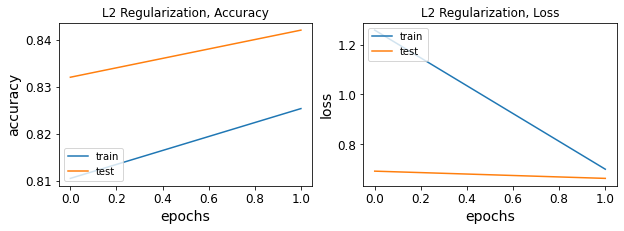

In [ ]:
plot_accuracy_and_loss(history, 'L2 Regularization')

Since you will typically want to apply the same regularizer to all layers in your network,
as well as the same activation function and the same initialization strategy in all
hidden layers, you may find yourself repeating the same arguments over and over.
This makes it ugly and error-prone. 

To avoid this, you can try refactoring your code
to use loops. Another option is to use Python’s `functools.partial()` function: it lets
you create a thin wrapper for any callable, with some default argument values.

In [ ]:
RegularizedDense = partial(Dense, activation='elu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01))

model = Sequential([
    Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100), 
    Dense(10, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01)),             
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

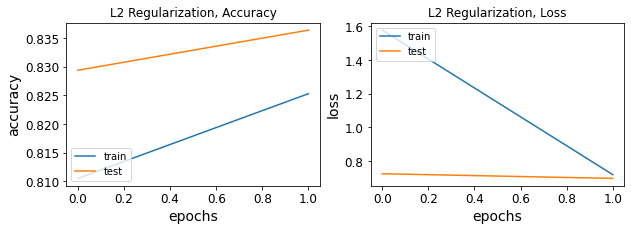

In [ ]:
plot_accuracy_and_loss(history, 'L2 Regularization')

## Dropout

Dropout is one of the most popular regularization techniques for deep neural networks and it has proven to be highly successful: even the state-ofthe-art neural networks got a 1–2% accuracy boost simply by adding dropout. 

This may not sound like a lot, but when a model already has 95% accuracy, getting a 2% accuracy boost means dropping the error rate by almost 40% (going from 5% error to roughly 3%).

It is a fairly simple algorithm: at every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability $p$ of being temporarily “dropped out,” meaning it will be entirely ignored during this training step, but it may be active during the next step The hyperparameter $p$ is called the dropout rate, and it is typically set to 50%. After training, neurons don’t get dropped anymore. And that’s all.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/dropout-regularization.PNG?raw=1' width='400'/>

To implement dropout using Keras, you can use the keras.layers.Dropout layer.
During training, it randomly drops some inputs (setting them to 0) and divides the
remaining inputs by the keep probability. After training, it does nothing at all, it just
passes the inputs to the next layer.

In [ ]:
keras_backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = Sequential([
    Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    Dense(300, activation='elu', kernel_initializer='lecun_normal'),
    keras.layers.Dropout(rate=0.2),
    Dense(100, activation='elu', kernel_initializer='lecun_normal'), 
    keras.layers.Dropout(rate=0.2),
    Dense(10, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01)),             
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

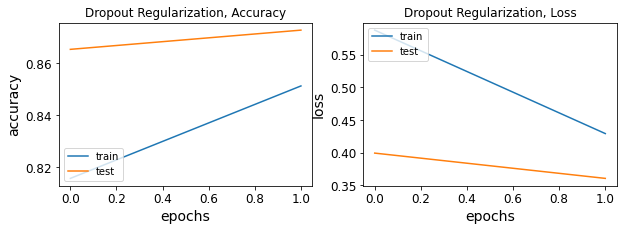

In [ ]:
plot_accuracy_and_loss(history, 'Dropout Regularization')

## Alpha Dropout

In [ ]:
keras_backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = Sequential([
    Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    Dense(300, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.AlphaDropout(rate=0.2),
    Dense(100, activation='selu', kernel_initializer='lecun_normal'), 
    keras.layers.AlphaDropout(rate=0.2),
    Dense(10, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01)),             
])

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

In [ ]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.5388 - accuracy: 0.8579


[0.5387945771217346, 0.8579000234603882]

In [ ]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.4232 - accuracy: 0.8794


[0.42316412925720215, 0.8794000148773193]

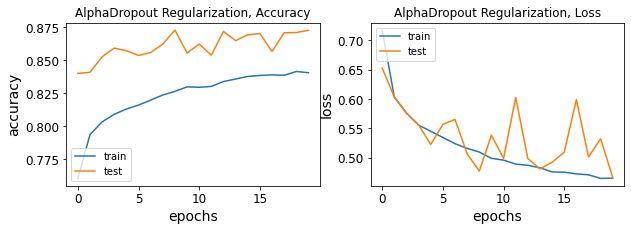

In [ ]:
plot_accuracy_and_loss(history, 'AlphaDropout Regularization')

If you observe that the model is overfitting, you can increase the dropout rate. Conversely,
you should try decreasing the dropout rate if the model underfits the training
set. It can also help to increase the dropout rate for large layers, and reduce it for
small ones. 

Moreover, many state-of-the-art architectures only use dropout after the
last hidden layer, so you may want to try this if full dropout is too strong.

Dropout does tend to significantly slow down convergence, but it usually results in a
much better model when tuned properly. 

So, it is generally well worth the extra time
and effort.

##Monte Carlo (MC) Dropout

In 2016, a [paper](https://arxiv.org/abs/1506.02142) by Yarin Gal and Zoubin Ghahramani added a few more good reasons to use dropout:

* First, there is a profound connection between dropout networks
(i.e., neural networks containing a Dropout layer before every weight layer) and approximate Bayesian inference, giving dropout a solid mathematical justification.
* Second, the authors introduced a powerful technique called MC Dropout, which
can boost the performance of any trained dropout model without having to
retrain it or even modify it at all, provides a much better measure of the model’s uncertainty, and is also amazingly simple to implement.



In [4]:
tf.random.set_seed(42)
np.random.seed(42)

It is the full implementation of MC Dropout, boosting the dropout model
we trained earlier without retraining it:

In [7]:
y_probas = np.stack([model(X_test_scaled, training=True) for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

We just make 100 predictions over the test set, setting `training=True` to ensure that the Dropout layer is active, and stack the predictions. Since dropout is active, all the
predictions will be different.

Recall that `predict()` returns a matrix with one row per
instance and one column per class. 

Because there are 10,000 instances in the test set and 10 classes, this is a matrix of shape `[10000, 10]`. We stack 100 such matrices, so
y_probas is an array of shape `[100, 10000, 10]`.

Once we average over the first dimension (axis=0), we get `y_proba`, an array of shape `[10000, 10]`, like we would get
with a single prediction. That’s all!

Averaging over multiple predictions with dropout
on gives us a Monte Carlo estimate that is generally more reliable than the result of a
single prediction with dropout off.

For example, let’s look at the model’s prediction
for the first instance in the Fashion MNIST test set, with dropout off:

In [8]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.18, 0.  , 0.82]],
      dtype=float32)

The model seems almost certain that this image belongs to class 9 (ankle boot).

Should you trust it? Is there really so little room for doubt? 

Compare this with the
predictions made when dropout is activated:

In [9]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.62, 0.  , 0.34]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.79, 0.  , 0.21]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.32, 0.  , 0.56]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.49, 0.  , 0.49]],

       [[0.  , 0.  , 0.  , 0.  , 0.01, 0.22, 0.01, 0.66, 0.  , 0.1 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.88]],

       [[0.02, 0.01, 0.  , 0.01, 0.01, 0.46, 0.13, 0.3 , 0.  , 0.05]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.48, 0.  , 0.46]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.19, 0.  , 0.77]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.1 , 0.  , 0.87]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.34, 0.  , 0.31, 0.  , 0.34]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.35, 0.  , 0.6 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.05, 0.17, 0.02, 0.44, 0.04, 0

This tells a very different story: apparently, when we activate dropout, the model is
not sure anymore. 

It still seems to prefer class 9, but sometimes it hesitates with
classes 5 (sandal) and 7 (sneaker), which makes sense given they’re all footwear. 

Once we average over the first dimension, we get the following MC Dropout predictions:

In [10]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.01, 0.42, 0.01, 0.44]],
      dtype=float32)

The model still thinks this image belongs to class 9, but only with a 44% confidence,
which seems much more reasonable than 99%. 

Plus it’s useful to know exactly which
other classes it thinks are likely. 

And you can also take a look at the standard deviation
of the probability estimates:

In [11]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.01, 0.  , 0.  , 0.  , 0.01, 0.16, 0.02, 0.25, 0.02, 0.26]],
      dtype=float32)

Apparently there’s quite a lot of variance in the probability estimates: **if you were building a risk-sensitive system (e.g., a medical or financial system), you should probably treat such an uncertain prediction with extreme caution**. You definitely would
not treat it like a 99% confident prediction. 

Moreover, the model’s accuracy got a
small boost from 86.8 to 86.9:

In [13]:
y_pred = np.argmax(y_proba, axis=1)
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8562

If your model contains other layers that behave in a special way during training (such as `BatchNormalization` layers), then you should not force training mode like we just did. 

Instead, you should replace the Dropout layers with the following `MCDropout`
class:

In [14]:
class MCDropout(keras.layers.Dropout):
  def call(self, inputs):
      return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
  def call(self, inputs):
      return super().call(inputs, training=True)

Here, we just subclass the Dropout layer and override the `call()` method to force its training argument to True.

If you are creating a model from
scratch, it’s just a matter of using MCDropout rather than Dropout.

But if you have a
model that was already trained using Dropout, you need to create a new model that’s
identical to the existing model except that it replaces the Dropout layers with MCDrop
out, then copy the existing model’s weights to your new model.

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

In [16]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer for layer in model.layers
])

In [17]:
mc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 mc_alpha_dropout (MCAlphaDr  (None, 784)              0         
 opout)                                                          
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 mc_alpha_dropout_1 (MCAlpha  (None, 300)              0         
 Dropout)                                                        
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 mc_alpha_dropout_2 (MCAlpha  (None, 100)             

In [18]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [19]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [20]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.4 , 0.01, 0.47]],
      dtype=float32)

In short, MC Dropout is a fantastic technique that boosts dropout models and provides
better uncertainty estimates. 

And of course, since it is just regular dropout during
training, it also acts like a regularizer.

## Max-Norm Regularization

Another regularization technique that is quite popular for neural networks is called max-norm regularization: for each neuron, it constrains the weights $w$ of the incoming
connections such that $|w|_2 ≤ r$, where $r$ is the max-norm hyperparameter
and $|.|_2$ is the $L_2$ norm.

Max-norm regularization does not add a regularization loss term to the overall loss
function. Instead, it is typically implemented by computing $|w|_2$ after each training
step and clipping $w$ if needed.

Reducing $r$ increases the amount of regularization and helps reduce overfitting. Maxnorm
regularization can also help alleviate the vanishing/exploding gradients problems
(if you are not using Batch Normalization).

To implement max-norm regularization in Keras, just set every hidden layer’s `kernel_constraint` argument to a `max_norm()` constraint, with the appropriate max value.

```python
keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                    kernel_constraint=keras.constraints.max_norm(1.))
```

In [ ]:
MaxNormDense = partial(keras.layers.Dense, 
                       activation='selu', 
                       kernel_initializer='lecun_normal',
                       kernel_constraint=keras.constraints.max_norm(1.))

model = Sequential([
    Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    Dense(10, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01)),             
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

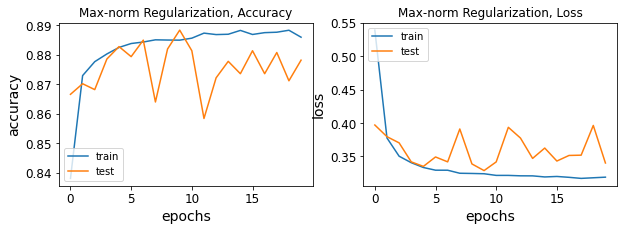

In [22]:
plot_accuracy_and_loss(history, 'Max-norm Regularization')

The `max_norm()` function has an axis argument that defaults to 0. A Dense layer usually
has weights of shape `[number of inputs, number of neurons]`, so using axis=0
means that the max norm constraint will apply independently to each neuron’s weight
vector. If you want to use max-norm with convolutional layers make sure to set the max_norm() constraint’s axis argument appropriately (usually
`axis=[0, 1, 2]`).

##Summary and Practical Guidelines

Don’t forget to normalize the input features! You should also try to reuse parts of a
pretrained neural network if you can find one that solves a similar problem, or use
unsupervised pretraining if you have a lot of unlabeled data, or use pretraining on an
auxiliary task if you have a lot of labeled data for a similar task.

While the guidelines should cover most cases, here are some exceptions:

* If you need a sparse model, you can use $L_1$ regularization (and optionally zero out
the tiny weights after training). If you need an even sparser model, you can use
the TensorFlow Model Optimization Toolkit. This will break self-normalization,
so you should use the default configuration in this case.

* If you need a low-latency model (one that performs lightning-fast predictions),
you may need to use fewer layers, fold the Batch Normalization layers into the
previous layers, and possibly use a faster activation function such as leaky ReLU
or just ReLU. Having a sparse model will also help. Finally, you may want to
reduce the float precision from 32 bits to 16 or even 8 bits.

* If you are building a risk-sensitive application, or inference latency is not very
important in your application, you can use MC Dropout to boost performance
and get more reliable probability estimates, along with uncertainty estimates.

